## Hepsiburada(Turkish Amazon) Comments - Positive and Negative Seperator

- We have a dataset for product review comments.

- We want to understand is review positive or negative with comments. 

>For this case we will use NLP techniques like Tokenizer and Sequence. 

>For model building we can use Tensorflow or PyTorch. 

>I want use GRU( RNN ) for build layers . 

## Importing

In [82]:
import numpy as np # for building arrays

import pandas as pd # for looking dataset

import tensorflow as tf

In [3]:
from tensorflow.python.keras.models import Sequential # for building keras models
from tensorflow.python.keras.layers import Dense, GRU, Embedding , CuDNNGRU # for building model layer ( I will use CuDNNGRU but If you don't have a Nvidia GPU or you don't install CUDA can use classic GRU layer.)
from tensorflow.keras.optimizers import Adam # Adam Optimizer for model optimizing
from tensorflow.python.keras.preprocessing.text import Tokenizer # Tokenizer for text transformation to tokens
from tensorflow.python.keras.preprocessing.sequence import pad_sequences # for fill with 0 to outlier length sentences. (in this case outlier length is 59)
from tensorflow.python.keras.models import load_model

<hr>

## Data Importing and Analysis with little human eyes

In [18]:
data = pd.read_csv('data\hepsiburada.csv')

In [19]:
data.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


So we have one column data of Rating. 
<br>Rating is emotion  we get from comments.
<br>1 - Positive  0 - Negative 

And other column gives comments.
<br> We will preprocess on comments before building model.


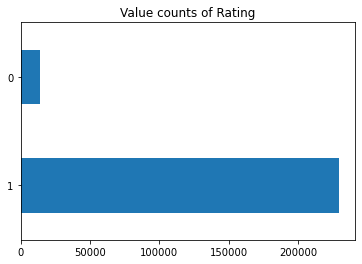

In [20]:
count_rating = data['Rating'].value_counts()

(count_rating .plot.barh()
 .set_title("Value counts of Rating"));

We have too much Positive comments but we don't need make any preprocessing because we have power of Neural Network.

<hr>

### Dependent and Independent values split (X and Y)

In [21]:
Y = data['Rating'].values.tolist()

In [22]:
x = data['Review'].values.tolist()

In [23]:
Y[0:5]

[1, 1, 1, 1, 1]

In [24]:
x[0:2]

['3 yıldır tık demedi. :)', '3 yıldır kullanıyorum müthiş ']

<hr>

### We assign cutoff value for train-test split. 

In [25]:
cutoff = int(len(x) * 0.80)

### Train test split with cutoff value (%80)

In [26]:
x_train , x_test = x[:cutoff], x[cutoff:]

In [27]:
y_train, y_test = Y[:cutoff], Y[cutoff:]

In [28]:
x_train[4]

'Günlük kullanımınızı çok çok iyi karsılıyor kısaca mükemmel'

In [29]:
y_train[4]

1

<hr>

### Exclude and tokenize less than 10000 repetitive words

In [30]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

In [31]:
tokenizer.fit_on_texts(x)

In [32]:
# tokenizer.word_index    for looking on it

In [33]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)

In [34]:
x_train[800]

'ürünü alalı 3 hafta kadar oldu. aralıksız kullanıyorum bilgisyarım sürekli açık durur ve ben günde yaklaşık 12 saat başındayım mousesu çok kullanırım. şimdiye kadar bir problem yaşamadım ve çok memnunum almak isteyenlere tavsiye ederim.'

In [35]:
print(x_train_tokens[800])

[19, 341, 52, 194, 30, 54, 7992, 55, 209, 603, 7887, 3, 36, 114, 164, 479, 85, 1, 1682, 782, 30, 2, 380, 326, 3, 1, 81, 132, 562, 9, 10]


In [36]:
x_test_tokens = tokenizer.texts_to_sequences(x_test)

...

...

...

#### RNN algoritmasına bu yorumları vermemiz için hepsinin aynı sayıda kelimeye yani token sayısına (vektörüne) sahip olması gerek

##### Kelimelerin sayısını bu şekilde bir liste oluşturucusu ile bulabiliriz

In [37]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]

In [38]:
num_tokens= np.array(num_tokens)

### Ortalama kelime sayısı

In [39]:
np.mean(num_tokens)

20.744703220162876

## En uzun yorum

In [40]:
np.max(num_tokens)

295

In [41]:
np.argmax(num_tokens)

21941

In [42]:
x_train[np.argmax(num_tokens)]

'Özellikle bu kısma yazıyorum iyice okuyunuz,cihazın hızı çok iyi.Isınma normal boyutlarda.Kamerası elinizi sabit tutarsanız ve gündüz çok net gece ise çok net çekmez.Görüntülü konuşma özelliği yok ancak uygulama ile olur,anten çekimi gayet iyi.Parmak izi okuyucusu gayet hızlı bazen tuşu silmenizi istiyor ve okuyamıyor kirden vs...Ön kamera da tatmin edici,çekim esnasında ekran beyaz ışık vererek flaş görevi görür.Batarya bana 1 hafta gidiyor sık kullanımda ise 2-3 gün gidiyor.Hızlı şarj 1 saatte doluyor , şekilleri ele oturuyor ve şık bir görüntü var.Telefonu aldığım gün gittim ve ilk girdiğim yerden ekran koruyucu ve kılıf buldum.Kulaklık sesi çok net ve yüksek ancak kendi hoparlörü biraz zayıf sesi.Ekrana bakarken açık kalma özelliği yok.Diğer akıllı cihaz özellikleri %90 ı bu cihazda mevcut.Güç tasarrufu 2 ayrı modu var ve çok başarılı çalışıyor.4gb ram var genelde yarısı boş kalıyor.Bir de yeni cihazların çoğu titreşimi az ve sesi de az çıkıyor.Bu cihaz da içine dahil...Bu cihazla

## Her yorumu aynı sayıda tokene sabitlemek için eşik eder oluşumu - 95 rule- (standart değer*2 + ortalama) 

In [43]:
max_tokens = int(np.mean(num_tokens)  + 2* np.std(num_tokens))

In [44]:
max_tokens

59

### 59 kelimeden az oluşan yorumlar verisetimizin yüzde doksan beşini oluşturuyor bu güzel bir rakam

In [45]:
np.sum(num_tokens < max_tokens)/ len(num_tokens)

0.9597982726686571

### Şimdi ise 59 tokenden az olan kelimeleri 59 tokene kadar 0 sayısıyla dolduran bir fonksiyon kullanarak train ve test atamalarını yapacağız

In [46]:
x_train_pad = pad_sequences(x_train_tokens, maxlen= max_tokens)

In [47]:
x_test_pad = pad_sequences(x_test_tokens, maxlen= max_tokens)

### Farkını bu şekilde inceleyebiliriz

In [48]:
np.array(x_train_tokens[800])

array([  19,  341,   52,  194,   30,   54, 7992,   55,  209,  603, 7887,
          3,   36,  114,  164,  479,   85,    1, 1682,  782,   30,    2,
        380,  326,    3,    1,   81,  132,  562,    9,   10])

In [49]:
x_train_pad[800]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,   19,  341,   52,  194,   30,
         54, 7992,   55,  209,  603, 7887,    3,   36,  114,  164,  479,
         85,    1, 1682,  782,   30,    2,  380,  326,    3,    1,   81,
        132,  562,    9,   10])

#### Gereksiz ve hatalı kelimeleri fonksiyon yazarak atma 

In [50]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [51]:
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [52]:
x_train[800]

'ürünü alalı 3 hafta kadar oldu. aralıksız kullanıyorum bilgisyarım sürekli açık durur ve ben günde yaklaşık 12 saat başındayım mousesu çok kullanırım. şimdiye kadar bir problem yaşamadım ve çok memnunum almak isteyenlere tavsiye ederim.'

In [53]:
tokens_to_string(x_train_tokens[800])

'ürünü alalı 3 hafta kadar oldu aralıksız kullanıyorum sürekli açık durur ve ben günde yaklaşık 12 saat çok kullanırım şimdiye kadar bir problem yaşamadım ve çok memnunum almak isteyenlere tavsiye ederim'

<hr>

# RNN - GRU

In [54]:
model = Sequential()

### Embedding

In [55]:
embedding_size = 50

In [56]:
model.add(Embedding(input_dim= num_words,
                   output_dim= embedding_size,
                   input_length= max_tokens,
                   name= 'embedding_layer'))

## 3-layer GRU

In [57]:
model.add(CuDNNGRU(units=16,return_sequences=True))
model.add(CuDNNGRU(units=8,return_sequences=True))
model.add(CuDNNGRU(units=4))
model.add(Dense(1, activation='sigmoid'))

In [58]:
optimizer = Adam(lr=1e-3)

In [59]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 59, 50)            500000    
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (None, 59, 16)            3264      
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 59, 8)             624       
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 4)                 168       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 504,061
Trainable params: 504,061
Non-trainable params: 0
_________________________________________________________________


In [61]:
x_train_pad = np.array(x_train_pad)

In [62]:
y_train = np.array(y_train)

In [63]:
model.fit(x_train_pad,y_train,epochs=5,batch_size=256)

Epoch 1/5
761/761 [==============================] - 16s 21ms/step - loss: 0.1548 - accuracy: 0.9558
Epoch 2/5
761/761 [==============================] - 15s 20ms/step - loss: 0.0876 - accuracy: 0.9710
Epoch 3/5
761/761 [==============================] - 16s 21ms/step - loss: 0.0695 - accuracy: 0.97800s - loss: 0.069 - ETA: 0s - loss: 0.0696 - accuracy: 0.
Epoch 4/5
761/761 [==============================] - 16s 20ms/step - loss: 0.0546 - accuracy: 0.9838
Epoch 5/5
761/761 [==============================] - 16s 20ms/step - loss: 0.0424 - accuracy: 0.9885


In [64]:
x_test_pad = np.array(x_test_pad)
y_test = np.array(y_test)

In [65]:
result = model.evaluate(x_test_pad,y_test)

1522/1522 [==============================] - 8s 5ms/step - loss: 0.1589 - accuracy: 0.9545


In [67]:
y_pred = model.predict(x=x_test_pad[0:1000])
y_pred = y_pred.T[0]

In [68]:
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in y_pred])

In [69]:
cls_true = np.array(y_test[0:1000])

In [70]:
incorrect = np.where(cls_pred != cls_true)
incorrect = incorrect[0]
len(incorrect)

53

In [71]:
idx = incorrect[0]
idx

5

In [72]:
text = x_test[idx]
text

'Ürün güzel ama teslimat çok geç yapıldı.'

In [73]:
y_pred[idx]

0.9703544

In [74]:
cls_true[idx]

0

In [75]:
text_ =['gereksiz bir ürün.']
token = tokenizer.texts_to_sequences(text_)
tok_pad = pad_sequences(token, maxlen= max_tokens)
tok_pad.shape

(1, 59)

In [76]:
model.predict(tok_pad)

array([[0.07373125]], dtype=float32)

In [1]:
model.save('hepsiburada_rnn.h5')

NameError: name 'model' is not defined

In [4]:
model_ = load_model('models/GRU_hepsiburada.model')